# Demo of application of TVMAGI in SEIRD model
In this notebook we illustrate how to use TVMAGI package to infer parameters from SEIRD model observations.

## 1. Load data
We use simulation data generated from data_generation.py, which includes 100 replications. We use the first replication data in the experiment for illustration purpose, and visualize the observation components: Suscepted (S), Exposed (E), Infected (I) and Dead (D).  

Text(0.5, 0, 'Days')

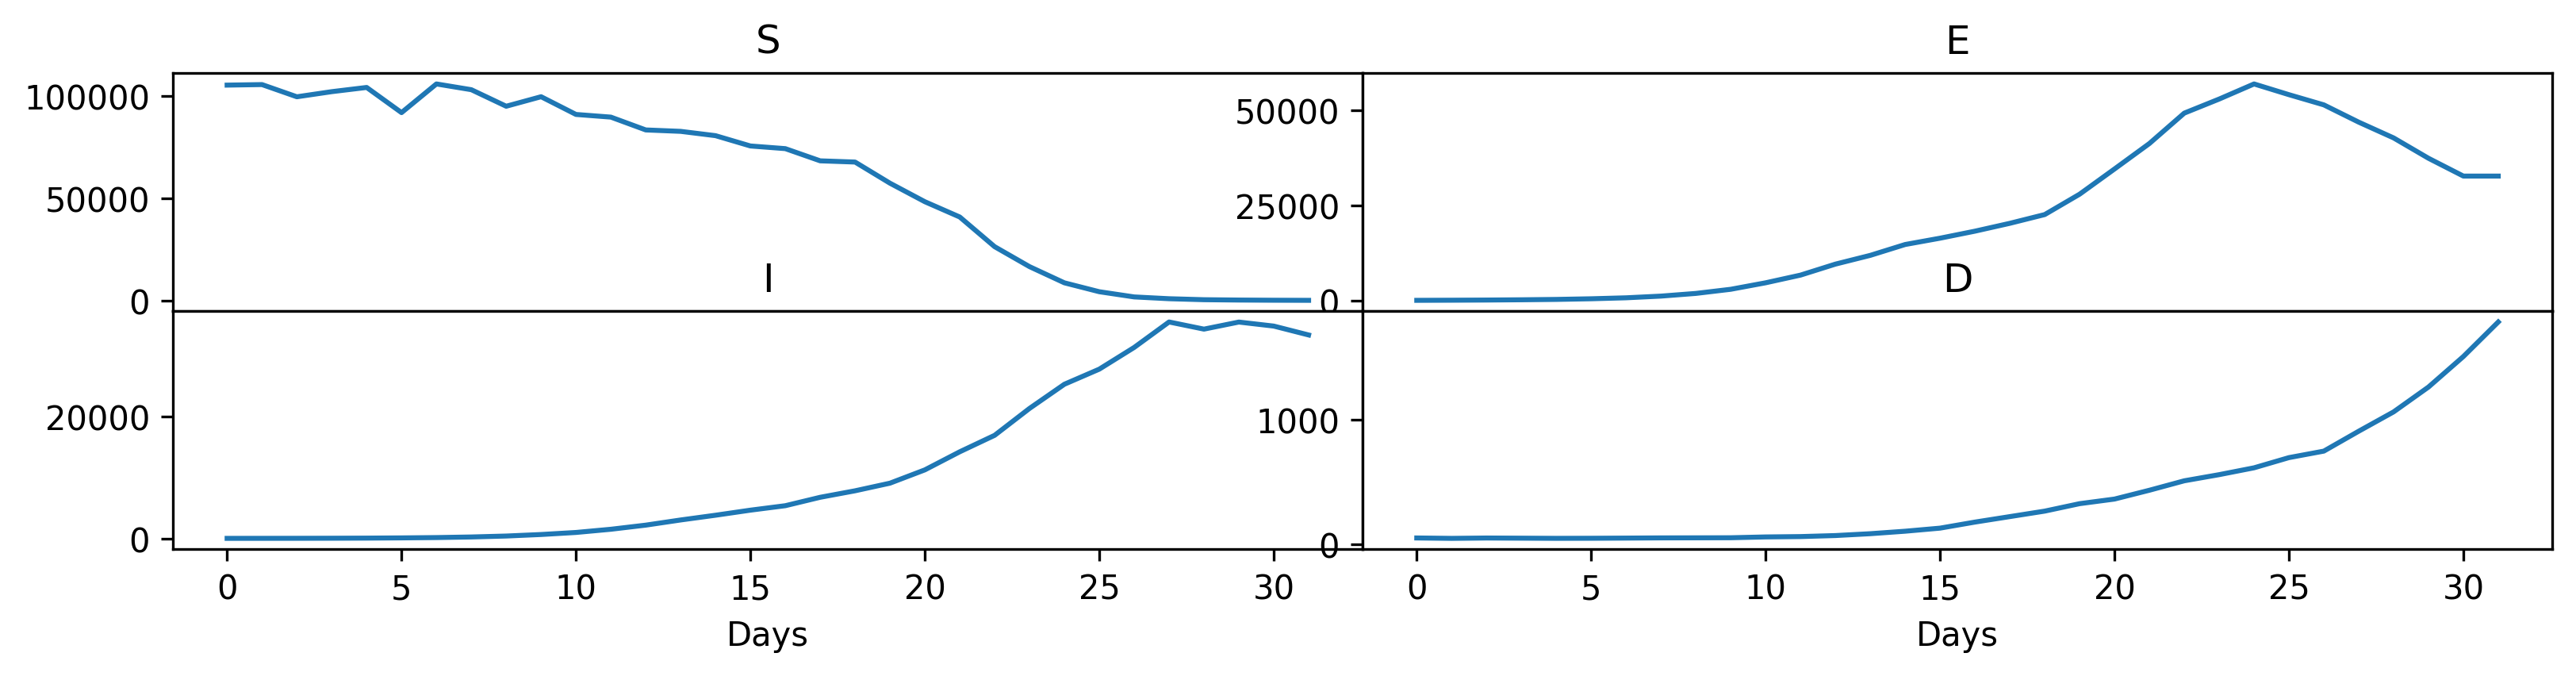

In [1]:
import sys
  
# setting path
sys.path.append('../')

import numpy as np
import torch
from system_derivative import *
from mean_MAGI import *
from pointwise_MAGI import *
from gpm import * 
from TV_MAGI import *
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
from IPython.core.pylabtools import figsize 

plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

torch.set_default_dtype(torch.double)
observations = np.load('data/SEIRD_observations.npy')[0]
observations[:, 1] = np.interp(np.arange(0, 32, 1), np.arange(0, 32, 2), observations[::2, 1])
figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(2, 2, 1)
plt.plot(np.exp(observations[:, 0]))
plt.title('S')
ax1 = plt.subplot(2, 2, 2)
plt.plot(np.exp(observations[:, 1]))
plt.title('E')
ax1 = plt.subplot(2, 2, 3)
plt.plot(np.exp(observations[:, 2]))
plt.title('I')
plt.xlabel('Days')
ax1 = plt.subplot(2, 2, 4)
plt.plot(np.exp(observations[:, 3]))
plt.title('D')
plt.xlabel('Days')

## 2. Set up configurations
As illustrated in the paper, $\beta$, $v^e$, and $p^d$ are assumed to be time varying, while $v^i$ is assumed as unknown constant. The observation lasts 32 days and discretization level is 2 per observation. After completing the module "system_dynamic.py", run the following codes for the first-stage problem (where all parameters are considered unknown constant):

In [2]:
tvecObs = np.arange(0, 32, 1.)
tvecFull = np.arange(0, 32, 0.5)
is_time_varying=[True, True, False, True]
SEIRD_model = system_dynamic(observations, is_time_varying, tvecObs, tvecFull, **{'N': 100000.}) 
mean_system = mean_model(SEIRD_model)
# results = mean_system.solve()

In [3]:
import pickle
# pickle.dump( results, open( "results.p", "wb" ) )
results = pickle.load( open( "results.p", "rb" ) )

## 3. Pointwise estimation and kernel estimation
Run the codes below for the second-stage optimization. As illustrated in the paper, the inferred pointwise estimation only maximizes the likelihood without considering the smoothness constraints of parameters. Therefore, the inferred results can be highly noisy, and tend to over-fit the data:

In [4]:
pointwise_system = pointwise_model(SEIRD_model, results, force_positive=[False, False, True])
pointwise_system.train()

1/50000 iteration: -79.477684


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


1001/50000 iteration: -153.713597
2001/50000 iteration: -190.668994
3001/50000 iteration: -266.763167
4001/50000 iteration: -334.762955
5001/50000 iteration: -340.515337
6001/50000 iteration: -384.649502
7001/50000 iteration: -353.987508
8001/50000 iteration: -374.810910
9001/50000 iteration: -386.627087
10001/50000 iteration: -391.798519
11001/50000 iteration: -393.736715
12001/50000 iteration: -395.859484
13001/50000 iteration: -398.405688
14001/50000 iteration: -401.563852
15001/50000 iteration: -405.294206
16001/50000 iteration: -409.248365
17001/50000 iteration: -412.815896
18001/50000 iteration: -415.452348
19001/50000 iteration: -417.070875
20001/50000 iteration: -417.938303
Optimization converges


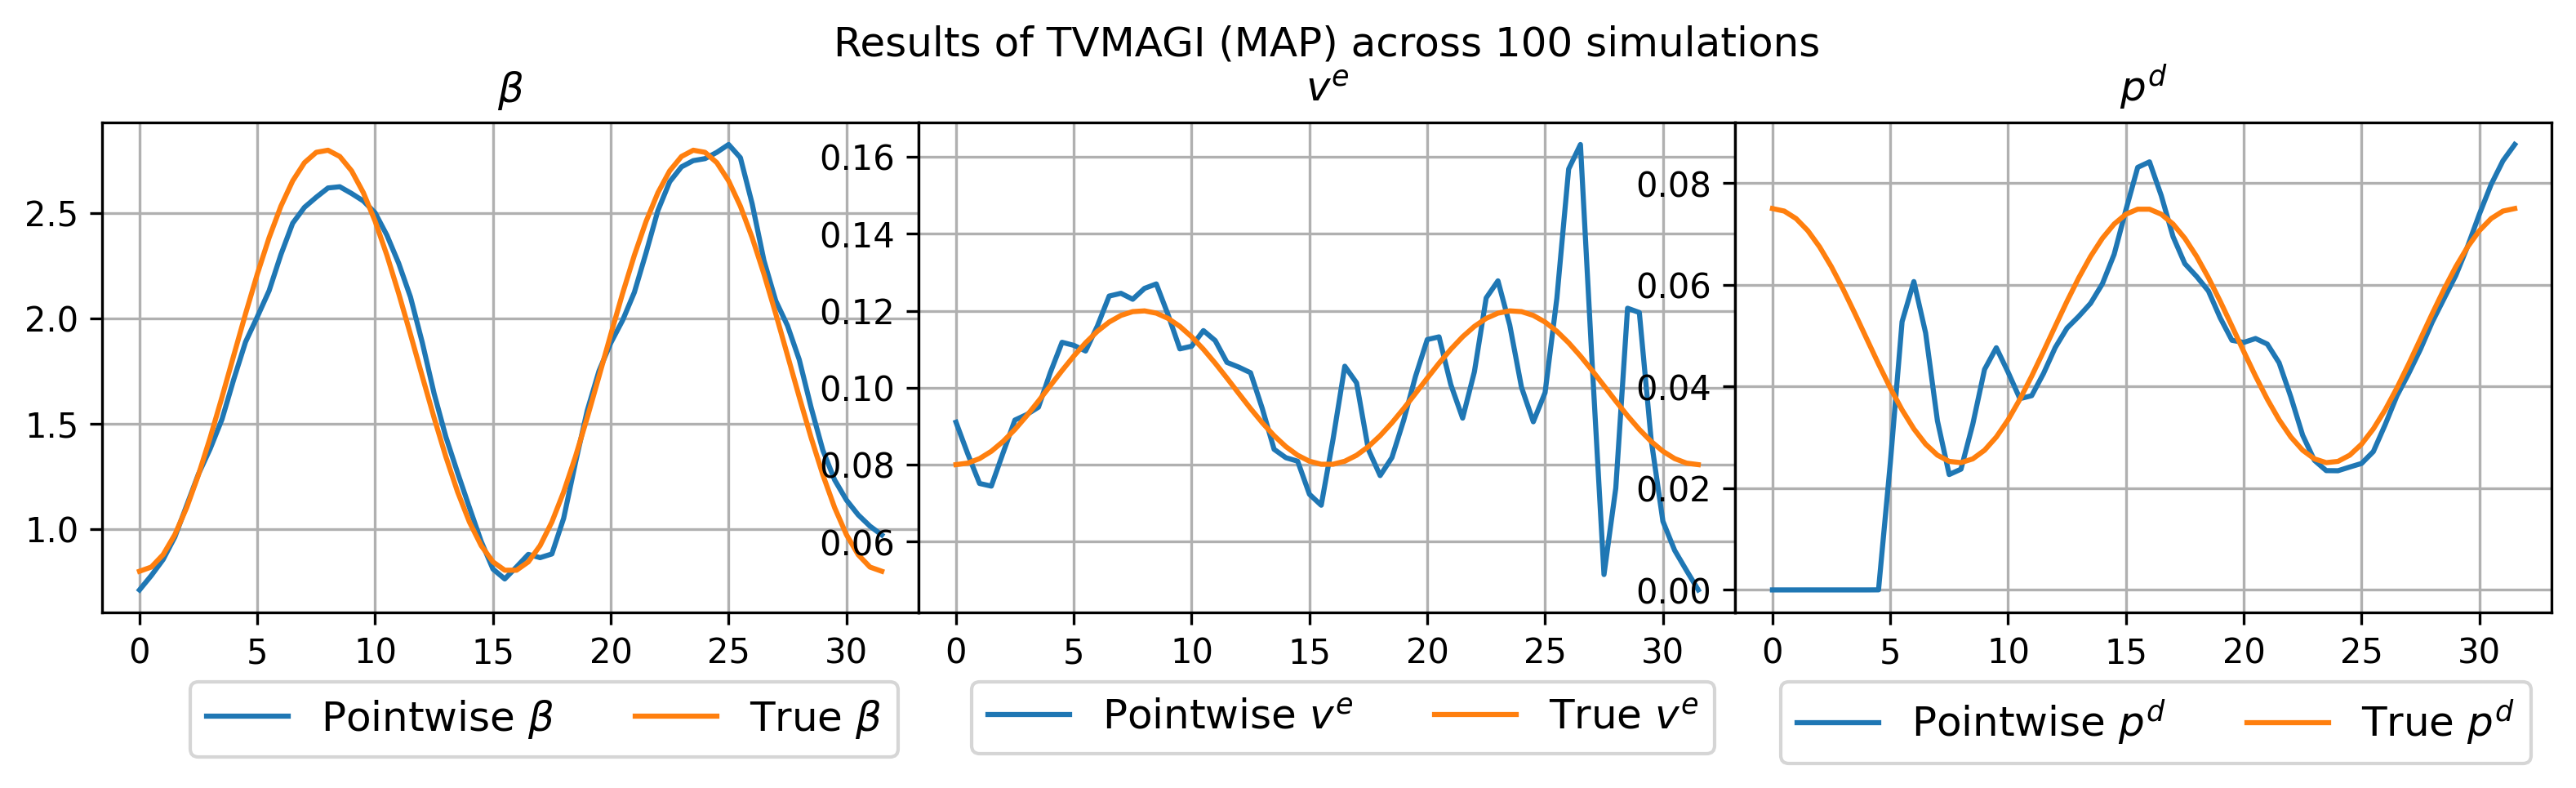

In [7]:
import matplotlib.pyplot as plt

figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
pointwise_theta = pointwise_system.pointwise_theta_torch.detach().numpy()

x = np.arange(0, 32, 0.5)
mean = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]
tmp_2 = np.linspace(0, 4 * np.pi, 64)
true_beta = mean[0] - std[0] * np.cos(tmp_2)
true_ve = mean[1]- std[1] * np.cos(tmp_2)
true_vi = mean[2]
true_pd = mean[3] + std[3] * np.cos(tmp_2)


ax1 = plt.subplot(1, 3, 1)
plt.plot(x, pointwise_theta[:, 0], label=r'Pointwise $\beta$')
plt.plot(x, true_beta, label=r'True $\beta$')
plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(1, -0.1), fontsize=12, ncol=2)

ax2 = plt.subplot(1, 3, 2)
plt.plot(x, pointwise_theta[:, 1], label=r'Pointwise $v^e$')
plt.plot(x, true_ve, label=r'True $v^e$')
plt.grid()
plt.title(r'$v^e$')
plt.legend(bbox_to_anchor=(1, -0.1), fontsize=12, ncol=2)
ax3 = plt.subplot(1, 3, 3)
plt.plot(x, pointwise_theta[:, 2]/4, label=r'Pointwise $p^d$') # recover from reparametrization
plt.plot(x, true_pd, label=r'True $p^d$')
plt.title(r'$p^d$')
plt.legend(bbox_to_anchor=(1, -0.1), fontsize=12, ncol=2)
plt.suptitle(r'Results of TVMAGI (MAP) across 100 simulations', y=1.2)
plt.grid()

## 4. TVMAGI MAP optimization
Run the codes below for final optimization. In this section we focus on the point estimation of parameters. 

In [8]:
KinvthetaList = estimate_kernel(pointwise_system, lengthscale_lb=6.0).KinvthetaList
TVMAGI_system = TVMAGI_model(pointwise_system, KinvthetaList)
TVMAGI_system.train(lr=1e-3)

1/50000 iteration: 681.024929
1001/50000 iteration: 249.433424
2001/50000 iteration: 70.435683
3001/50000 iteration: -34.178779
4001/50000 iteration: -99.158118
5001/50000 iteration: -143.118493
6001/50000 iteration: -169.149790
7001/50000 iteration: -189.677555
8001/50000 iteration: -206.370616
9001/50000 iteration: -220.636679
10001/50000 iteration: -233.739098
11001/50000 iteration: -244.033405
12001/50000 iteration: -254.425584
13001/50000 iteration: -265.050408
14001/50000 iteration: -276.011385
15001/50000 iteration: -287.305781
16001/50000 iteration: -296.285551
17001/50000 iteration: -304.530051
18001/50000 iteration: -311.484198
19001/50000 iteration: -318.000856
20001/50000 iteration: -324.773376
21001/50000 iteration: -330.405718
22001/50000 iteration: -336.238827
23001/50000 iteration: -342.298031
24001/50000 iteration: -348.577133
25001/50000 iteration: -355.013397
26001/50000 iteration: -360.161610
27001/50000 iteration: -365.139800
28001/50000 iteration: -369.674557
2900

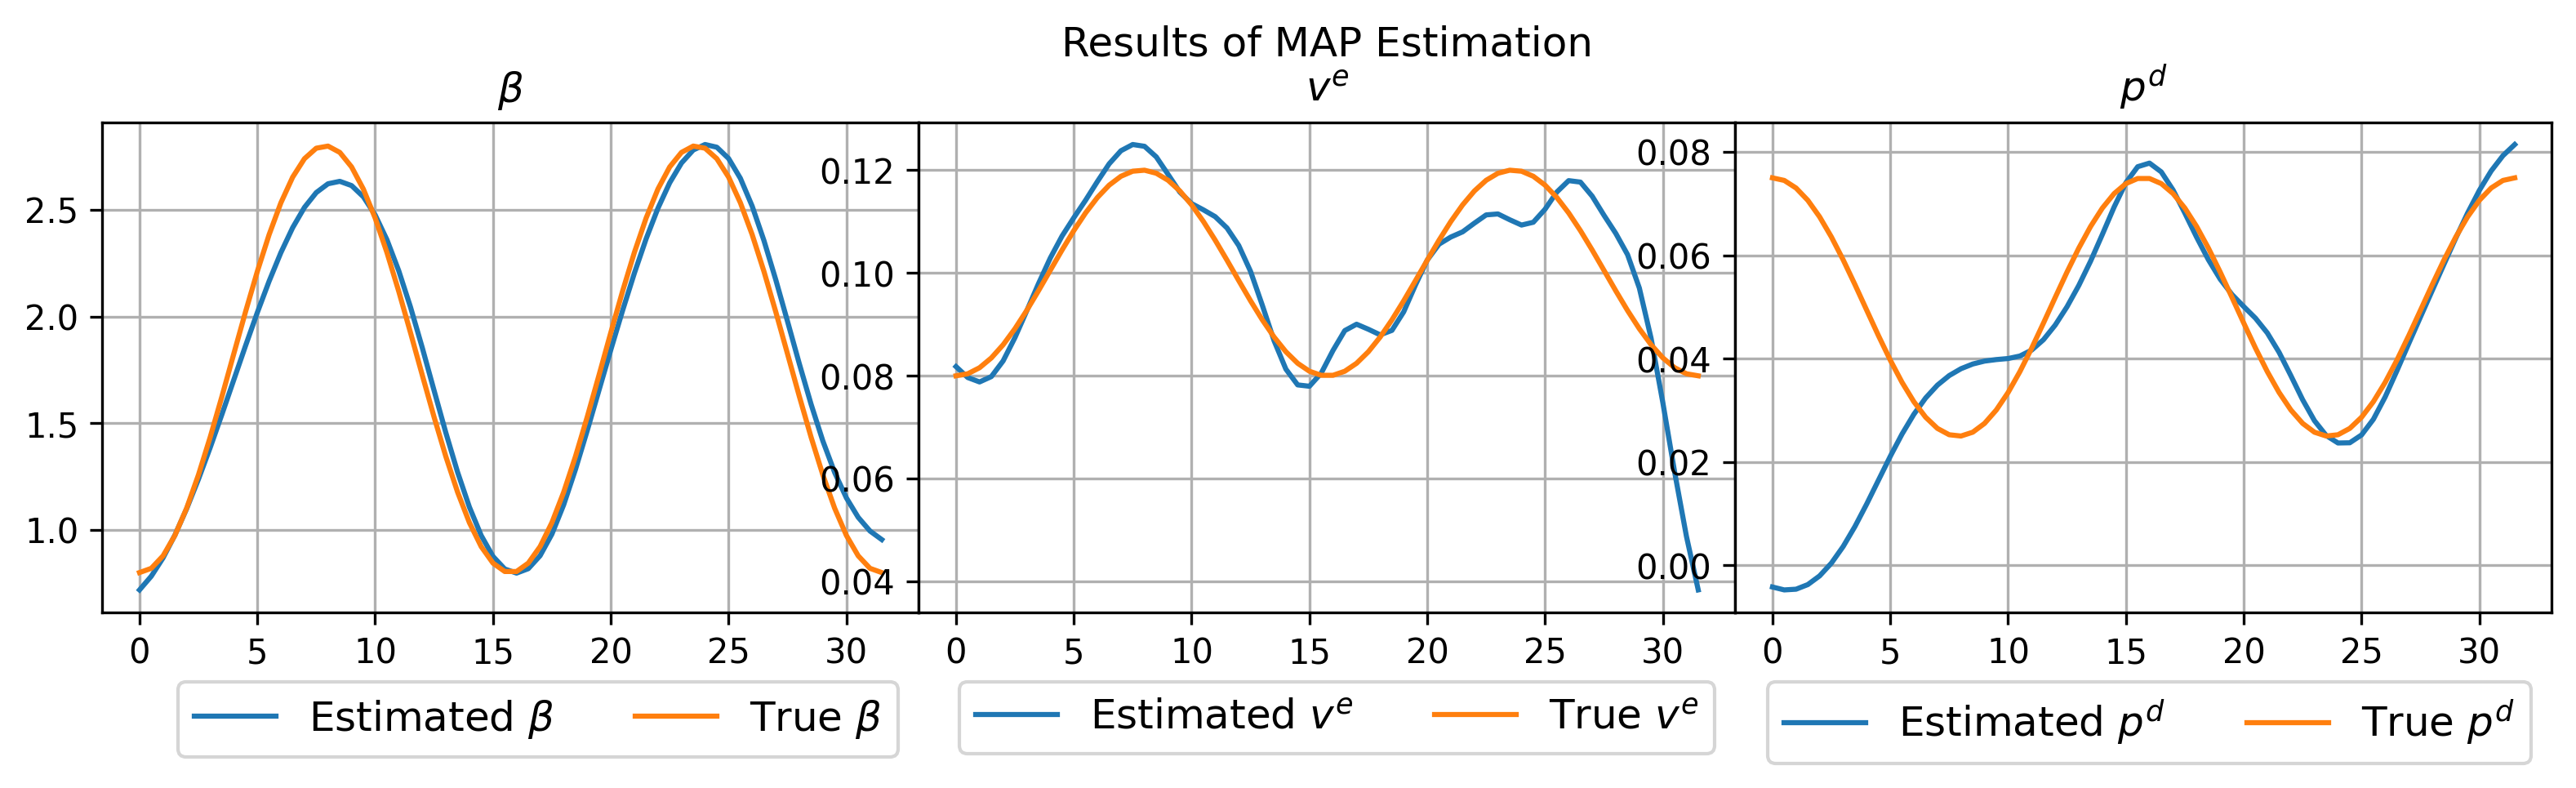

In [9]:
plt.plot(TVMAGI_system.TVMAGI_theta_torch.detach().numpy()[:, 1])
figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
TVMAGI_theta = TVMAGI_system.TVMAGI_theta_torch.detach().numpy()

x = np.arange(0, 32, 0.5)
mean = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]
tmp_2 = np.linspace(0, 4 * np.pi, 64)
true_beta = mean[0] - std[0] * np.cos(tmp_2)
true_ve = mean[1]- std[1] * np.cos(tmp_2)
true_vi = mean[2]
true_pd = mean[3] + std[3] * np.cos(tmp_2)


ax1 = plt.subplot(1, 3, 1)
plt.plot(x, TVMAGI_theta[:, 0], label=r'Estimated $\beta$')
plt.plot(x, true_beta, label=r'True $\beta$')
plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(1, -0.1), fontsize=12, ncol=2)

ax2 = plt.subplot(1, 3, 2)
plt.plot(x, TVMAGI_theta[:, 1], label=r'Estimated $v^e$')
plt.plot(x, true_ve, label=r'True $v^e$')
plt.grid()
plt.title(r'$v^e$')
plt.legend(bbox_to_anchor=(1, -0.1), fontsize=12, ncol=2)
ax3 = plt.subplot(1, 3, 3)
plt.plot(x, TVMAGI_theta[:, 2]/4, label=r'Estimated $p^d$') # recover from reparametrization
plt.plot(x, true_pd, label=r'True $p^d$')
plt.title(r'$p^d$')
plt.legend(bbox_to_anchor=(1, -0.1), fontsize=12, ncol=2)
plt.suptitle(r'Results of MAP Estimation', y=1.2)
plt.grid()